In [322]:
from selenium import webdriver
import pandas as pd
import time
import itertools
import pprint
import json
import re
from IPython.display import display
from IPython.display import clear_output
from matplotlib import pyplot as plt
pd.set_option('display.max_colwidth', -1)

In [34]:
driver = webdriver.Chrome('/usr/bin/chromedriver')

# get all settlements links

In [ ]:
driver.get('https://www.gov.il/he/departments/news/?OfficeId=104cb0f4-d65a-4692-b590-94af928c19c0&limit=10&topic=3ef9cac8-a1a9-4352-91d4-860efd3b720d&subTopic=626a30f9-8b50-495a-9b9f-e4ce4b433ca5')

In [ ]:
settlements_url_list_of_lists = []
while True:
    series = pd.Series(driver.page_source.split(' '))
    settlements_url_list = series[series.str.contains('-corona')].apply(lambda x: x[6:-1]).tolist()
    settlements_url_list_of_lists.append(settlements_url_list)
    element = driver.find_elements_by_xpath("//div[contains(@class, 'button-gov blue xs-pl-5 xs-pr-5')]")[1]
    if element.is_displayed():
        element.click()
        time.sleep(0.25)
    else:
        break

In [ ]:
all_settlements_list = list(itertools.chain.from_iterable(settlements_url_list_of_lists))
all_settlements_series = pd.Series(pd.Series(all_settlements_list).unique())
display(all_settlements_series.shape)
display(all_settlements_series.head())

In [ ]:
all_cities_series = pd.read_csv('./all_cities_links.csv', header=None)[0]
display(all_cities_series.head())
display(all_cities_series.shape)

# get settlements datums

In [62]:
def get_city_data(driver):
    main_xpath = '//div[@class=\'margin-for-ul txt dark-gray-txt lg-mb-30 tbl-accesabilty tbl-responsive sub-links-permanent-underline\']//'
    xpath = f'{main_xpath}h3 | {main_xpath}h2 | {main_xpath}p | {main_xpath}li'
    elements_list = driver.find_elements_by_xpath(xpath)
    datum_list = [element.text for element in elements_list]
    b = pd.Series(datum_list)
    datum_clean_list = b[:b[b.str.contains('הנחיות לציבור')].index[0]].tolist()
    return datum_clean_list

In [63]:
all_settlements_dict = {}

for index, city_link in enumerate(all_cities_series):        
    driver.get(city_link)
    time.sleep(0.25)
    clear_output(wait=True) 
    city_datum_list = get_city_data(driver)
    all_settlements_dict[city_link] = {'title': driver.title, 'datum': city_datum_list}    
    print(f'{index + 1} / {len(all_cities_series)}: {city_link}')
    print(all_settlements_dict[city_link])

194 / 194: https://www.gov.il/he/departments/news/nof-hagalil-corona
{'title': 'נוף הגליל - מקומות בהם שהו חולי קורונה | משרד הבריאות', 'datum': ['מקומות בהם שהו חולי קורונה בנוף הגליל', 'תאריך עדכון: 20/04/2020', '16/04/2020 14:00 16/04/2020 14:45 משהדאוי קינג סטור המוביל נוף הגליל', '16/04/2020 12:30 16/04/2020 13:45 מרכאזה העבודה 1 נוף הגליל', '14/04/2020 14:00 14/04/2020 16:00 מרכאזה העבודה 1 נוף הגליל', 'תאריך עדכון: 17/04/2020', '11.4.20, 12:00-13:00 - רשת המזון"MERKAZA", נוף הגליל', '11.4.20, 12:00-13:00 - רשת מזון"MERKAZA", נוף הגליל', 'תאריך עדכון 11/04/2020', '4.4.20, 13:00-14:00 - מרכז המזון, נוף הגליל', '29.3.20, 8:00-18:00 - עיריית נוף הגליל, נוף הגליל', 'תאריך עדכון 05/04/2020', '29.3.2020 16:30 - 17:30 בית העלין נוף הגליל', 'תאריך עדכון: 01/04/2020', '24/3/2020 20:30 - 21:30 אושר עד', '25/3/2020 19:00 - 21:30 עיריית נוף הגליל - אריזת אוכל לקשישים', 'תאריך עדכון: 31/03/2020', '18/03/2020 16:00 -18:00 סופרמרקט אושר עד נוף הגליל', 'תאריך עדכון: 24/03/2020 22:00', "13.3 09:0

In [194]:
all_settlements_dict = settlements_dict

In [195]:
with open('all_settlements_dict.json', 'w') as fp:
    json.dump(all_settlements_dict, fp)
with open('all_settlements_dict.json', 'r') as fp:
    all_settlements_dict = json.load(fp)

# extract incident date

In [303]:
def get_update_date_if_update(row):
    if 'עדכון' in re.findall('עדכון|עודכן', row['raw']):
        return get_date_from_string(row['raw'])
    else:
        return None

In [304]:
def get_date_from_string(string):
    date_strings_list = re.findall('\d{1,2}\.\d{1,2}\.\d{1,2}|\d{1,2}/\d{1,2}/\d\d', string)
    if date_strings_list:
        date = pd.to_datetime(date_strings_list[0], dayfirst=True)
    else:
        date_strings_list_2 = re.findall('\d{1,2}\.\d{1,2}', string)
        if date_strings_list_2:
            if date_strings_list_2[0] == '24.32':
                date_strings_list_2[0] = '24.3'
            date = pd.to_datetime(date_strings_list_2[0] + '.20', dayfirst=True)
        else:
            date = None
    return date

In [312]:
def get_settlement_df(settlement_link, settlement_dict):
    settlement_name = " ".join(settlement_dict['title'].split()[:-9])
    df = pd.Series(settlement_dict['datum']).to_frame('raw')
    df['update_date_temp'] = df.apply(get_update_date_if_update, axis=1)
    df['update_date'] = df['update_date_temp'].ffill()
    clean_df = df[~df['update_date_temp'].notna()][['raw', 'update_date']].dropna(subset=['update_date'])
    clean_df['incident_day'] = clean_df['raw'].apply(get_date_from_string)
    clean_df['settlement_name'] = settlement_name
    clean_df['settlement_link'] = settlement_link
    return clean_df

In [314]:
temp_df = [get_settlement_df(key, value) for key, value in all_settlements_dict.items()]
incidents_df = pd.concat(temp_df).reset_index(drop=True)
incidents_df.head()

,raw,update_date,incident_day,settlement_name,settlement_link
0,"10/04/2020 11:00- 13:00 מכולת ח'ריס מולא- ליד בניין מועצה מקומית , ירכא",2020-04-23,2020-04-10,ירכא,https://www.gov.il/he/departments/news/yarka-corona
1,"13/04/2020 20:30- 22:30 מרכז המזון , ירכא",2020-04-21,2020-04-13,ירכא,https://www.gov.il/he/departments/news/yarka-corona
2,"11.4.20, 10:00-13:00 - מרכז המזון ירכא, ירכא",2020-04-17,2020-04-11,ירכא,https://www.gov.il/he/departments/news/yarka-corona
3,"11.4.20, 10:00-13:00 - מרכז מזון ירכא, ירכא",2020-04-17,2020-04-11,ירכא,https://www.gov.il/he/departments/news/yarka-corona
4,"30/3/2020 - 15:00 עד 16:00 - מרקזא, ירכא",2020-04-13,2020-03-30,ירכא,https://www.gov.il/he/departments/news/yarka-corona


In [316]:
incidents_df[incidents_df['incident_day'] == '2020-04-29']

,raw,update_date,incident_day,settlement_name,settlement_link
6128,29.4.2020 19:00 - 20:00 מחסני השוק מיתרים,2020-04-05,2020-04-29,שמעה,https://www.gov.il/he/departments/news/shomaa-corona


In [317]:
incidents_df[incidents_df['incident_day'] == '2020-01-04']

,raw,update_date,incident_day,settlement_name,settlement_link
3991,4/1/2020 8:00 - 8:30 פיצה שמש רח' תרצה,2020-04-05,2020-01-04,רמת גן,https://www.gov.il/he/departments/news/ramat-gan-corona
3992,4/1/2020 8:00 - 8:30 מאור הפיצה רח' אריה בן אליעזר 24,2020-04-05,2020-01-04,רמת גן,https://www.gov.il/he/departments/news/ramat-gan-corona
4634,4/1/2020 9:30 - 18:00 הוסטל בית גיא רח' פנחס בן דוד 5,2020-04-05,2020-01-04,ראשון לציון,https://www.gov.il/he/departments/news/-rishon-lezion-corona


In [346]:
incidents_stat_df = incidents_df.groupby('incident_day').size().to_frame('size').reset_index()

In [345]:
incidents_clean_stat_df = incidents_stat_df[(incidents_stat_df['incident_day'] >= '2020-03-01') & (incidents_stat_df['incident_day'] <= '2020-04-24')]
incidents_clean_stat_df.sample(5)

,incident_day,size
23,2020-03-26,278
16,2020-03-19,300
1,2020-03-01,3
46,2020-04-18,8
31,2020-04-03,119


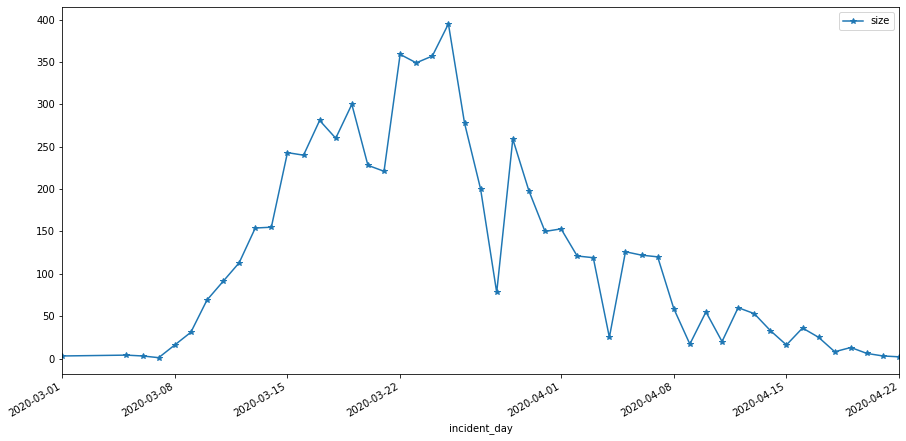

In [344]:
incidents_clean_stat_df.plot(x='incident_day', y='size', marker='*')